In [10]:
import pandas as pd
import gridstatus as gs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [11]:
# Create CAISO API instance
caiso = gs.CAISO()

In [12]:
# Grab energy data from CAISO
df = caiso.get_fuel_mix(start = "2024-07-01", end = "2024-07-04")

100%|██████████| 3/3 [00:01<00:00,  1.71it/s]


In [13]:
# Convert to Pacific Time, then strip the timezone "tag" so matplotlib plots it as local time
df['Time'] = df['Time'].dt.tz_convert('US/Pacific').dt.tz_localize(None)

In [14]:
df.head()

,Time,Interval Start,Interval End,Solar,Wind,Geothermal,Biomass,Biogas,Small Hydro,Coal,Nuclear,Natural Gas,Large Hydro,Batteries,Imports,Other
0,2024-07-01 00:00:00,2024-07-01 00:00:00-07:00,2024-07-01 00:05:00-07:00,231,4271,786,241,188,299,0,2274,8410,3094,-478,7680,0
1,2024-07-01 00:05:00,2024-07-01 00:05:00-07:00,2024-07-01 00:10:00-07:00,230,4318,785,241,188,298,0,2273,8251,3125,-225,7916,0
2,2024-07-01 00:10:00,2024-07-01 00:10:00-07:00,2024-07-01 00:15:00-07:00,230,4376,787,241,188,297,0,2274,7953,3164,-27,8032,0
3,2024-07-01 00:15:00,2024-07-01 00:15:00-07:00,2024-07-01 00:20:00-07:00,230,4401,786,241,189,297,0,2273,7725,3163,-99,8190,0
4,2024-07-01 00:20:00,2024-07-01 00:20:00-07:00,2024-07-01 00:25:00-07:00,231,4456,786,243,189,297,0,2273,7480,3158,87,8147,0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864 entries, 0 to 863
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype                     
---  ------          --------------  -----                     
 0   Time            864 non-null    datetime64[ns]            
 1   Interval Start  864 non-null    datetime64[ns, US/Pacific]
 2   Interval End    864 non-null    datetime64[ns, US/Pacific]
 3   Solar           864 non-null    int64                     
 4   Wind            864 non-null    int64                     
 5   Geothermal      864 non-null    int64                     
 6   Biomass         864 non-null    int64                     
 7   Biogas          864 non-null    int64                     
 8   Small Hydro     864 non-null    int64                     
 9   Coal            864 non-null    int64                     
 10  Nuclear         864 non-null    int64                     
 11  Natural Gas     864 non-null    int64                     

In [16]:
# Create a new column which is the sum of solar and battery energy output
df['Combined'] = df[['Solar','Batteries']].sum(axis=1)

In [17]:
# Just in case the data isn't sorted chronologically
df = df.sort_values('Time')

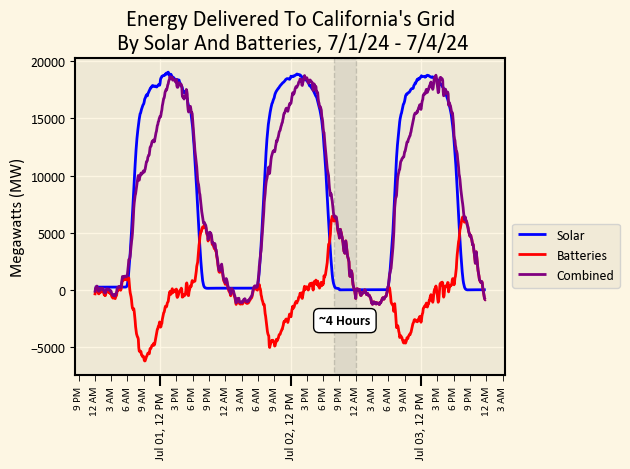

In [18]:
# Generate the plot.
plt.style.use(['Solarize_Light2', 'btt_style'])
    
fig,ax = plt.subplots()

ax.plot(df['Time'], df['Solar'], label = 'Solar', color = 'blue')
ax.plot(df['Time'], df['Batteries'], label = 'Batteries', color = 'red')
ax.plot(df['Time'], df['Combined'], label = 'Combined', color = 'purple')


ax.xaxis.set_major_locator(mdates.HourLocator(byhour=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, 12 PM'))
ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 3)))

# Custom function to format minor labels (removes leading zeros and skips 12 PM)
def custom_minor_labels(x, pos):
    dt = mdates.num2date(x)
    if dt.hour == 12:
        return "" # Don't print a minor label at noon to avoid overlapping the major label
    return dt.strftime('%I %p').lstrip('0') # Format as "3PM", "6AM", etc.

ax.xaxis.set_minor_formatter(plt.FuncFormatter(custom_minor_labels))

ax.tick_params(axis='x', which='major', length=8, width=1.5, labelsize = 9, labelrotation=90)
ax.tick_params(axis='x', which='minor', length=4, labelsize=8, labelrotation=90)


ax.set_title("Energy Delivered To California's Grid\n By Solar And Batteries, 7/1/24 - 7/4/24", fontsize=16)
ax.set_ylabel('Megawatts (MW)')
ax.legend(bbox_to_anchor=(1.0, 0.5))

# --- ANNOTATION: HIGHLIGHT LAG ZONE ---

# 1. Define the exact start and end times for the lag zone (July 2nd 8 PM to Midnight)
lag_start = pd.to_datetime('2024-07-02 20:00:00')
lag_end = pd.to_datetime('2024-07-03 00:00:00')

# 2. Draw a shaded region with a subtle border to highlight the gap
ax.axvspan(lag_start, lag_end, facecolor='gray', alpha=0.15, edgecolor='black', linestyle='--', linewidth=1)

# 3. Calculate the middle of that time window to center our text
midpoint = lag_start + (lag_end - lag_start) / 2

# 4. Add the "~4 Hours" text box. 
# We're placing it at 7500 MW on the Y-axis so it floats nicely in the empty space.
ax.text(midpoint, -2700, '~4 Hours', 
        horizontalalignment='center', verticalalignment='center', 
        fontsize=10, fontweight='bold',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4'))

# --- END ANNOTATION ---

fig.tight_layout()
fig.savefig('solar_and_battery_energy.png', dpi=600)

plt.show()


